In [9]:
# This notebook fits MNE model parameters to stimulus spectrgram segments that have been normalized
# to fall on to a fixed radius sphere in n-dim space

#to use, it is recommended to install the MNE_tf2 environment 

import numpy as np
from oe_acute import MNE2
from oe_acute import trial_utils as tu
# from oe_acute import reconstruct as rct
import os
import pickle
import glob
import logging
import pandas as pd
import tqdm
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.io import wavfile
from scipy import signal
from joblib import Parallel,delayed
from importlib import reload
import noisereduce as nr
import copy 
logger = logging.getLogger()
handler = logging.StreamHandler()
formatter = logging.Formatter(
        '%(asctime)s %(name)-12s %(levelname)-8s %(message)s')
handler.setFormatter(formatter)
logger.addHandler(handler)
logger.setLevel(logging.INFO)

from ceciestunepipe.file import bcistructure as et
from ceciestunepipe.util import sglxutil as sglu

plt.rcParams['lines.linewidth'] = 0.1

os.environ["KILOSORT2_PATH"] = '/mnt/cube/earneodo/repos/Kilosort2'
os.environ["KILOSORT3_PATH"] = '/home/finch/repos/Kilosort'
os.environ["NPY_MATLAB_PATH"] = '/mnt/cube/earneodo/repos/npy-matlab'

from ceciestunepipe.file import bcistructure as et
from ceciestunepipe.util import sglxutil as sglu
from ceciestunepipe.util import syncutil as su
from ceciestunepipe.util import wavutil as wu
logger.info('all modules loaded')

2023-02-21 12:57:52,143 root         INFO     all modules loaded
2023-02-21 12:57:52,143 root         INFO     all modules loaded


In [2]:
def get_window_spikes(spk_df, clu_list, start_sample, end_sample):
    onset = start_sample
    offset = end_sample
    
    spk_t = spk_df.loc[spk_df['times'].between(onset, offset, inclusive=False)]
    
    spk_arr = np.zeros((clu_list.size, offset - onset))

    for i, clu_id in enumerate(clu_list):
        clu_spk_t = spk_t.loc[spk_t['clusters']==clu_id, 'times'].values
        spk_arr[i, clu_spk_t - onset] = 1
    return spk_arr

def collect_bout(bout_dict, bout_idx, t_pre, t_post, spk_df, clu_list, mic_stream):
    s_f_ap = bout_dict['s_f_ap_0']
    s_f_wav = bout_dict['s_f']
    
    ## add the length of the bout (in seconds) to the end of the segment
    t_post += int(bout_dict['len_ms'][bout_idx] * 0.001)
       
    start_ap = bout_dict['start_sample_ap_0'][bout_idx] + int(s_f_ap* t_pre)
    end_ap = bout_dict['start_sample_ap_0'][bout_idx] + int(s_f_ap * t_post)

    start_wav = bout_dict['start_sample_wav'][bout_idx] + int(s_f_wav * t_pre)
    end_wav = bout_dict['start_sample_wav'][bout_idx] + int(s_f_wav * t_post)


    # get the streams/spike array
    spk_arr = get_window_spikes(spk_df, clu_list, int(start_ap), int(end_ap))
    mic_arr = mic_stream.flatten()[start_wav: end_wav]
    
    return spk_arr, mic_arr

# Load and Format Data

### requried inputs include information about the bird, session, and location of the data 
#### still need to run if loading MNE 

In [3]:
bird = 's_b1253_21'
all_bird_sess = et.list_sessions(bird)

sess_par = {'bird': 's_b1253_21',
           'sess': '2021-06-14',
           'probe': 'probe_0',
           'sort': 'sort_0'}

#all of this pulls the derived data for the clusters and spikes 
exp_struct = et.get_exp_struct(sess_par['bird'], sess_par['sess'], sort=sess_par['sort'])
ksort_folder = exp_struct['folders']['ksort']
raw_folder = exp_struct['folders']['sglx']
sess_epochs = et.list_sgl_epochs(sess_par)
epoch = sess_epochs[0]
sess_par['epoch'] = epoch
sess_par['sort'] = 'sort_0'
exp_struct = et.sgl_struct(sess_par, epoch)
sgl_folders, sgl_files = sglu.sgl_file_struct(exp_struct['folders']['sglx'])
bout_dict_path = os.path.join(exp_struct['folders']['sort'], 'bout_dict_ap0.pkl')
with open(bout_dict_path, 'rb') as handle:
    bout_dict = pickle.load(handle)
wav_mic_path = exp_struct['files']['wav_mic']
s_f_wav, mic_stream = wu.read_wav_chan(exp_struct['files']['wav_mic'])
#logger.info('Will load cluster, spike dataframes from ' + exp_struct2['folders']['sort'])
clu_df_path = os.path.join(exp_struct['folders']['sort'], 'clu_df.pkl')
clu_df = pd.read_pickle(clu_df_path)
spk_df_path = os.path.join(exp_struct['folders']['sort'], 'spk_df.pkl')
spk_df = pd.read_pickle(spk_df_path)
print(bout_dict.keys())
clu_df.head()

2023-02-21 12:53:35,826 ceciestunepipe.file.bcistructure INFO     {'folders': {'bird': '/mnt/sphere/speech_bci/raw_data/s_b1253_21', 'raw': '/mnt/sphere/speech_bci/raw_data/s_b1253_21/2021-06-14', 'sglx': '/mnt/sphere/speech_bci/raw_data/s_b1253_21/2021-06-14/sglx', 'kwik': '/scratch/earneodo/s_b1253_21/sglx/kwik/2021-06-14', 'processed': '/mnt/sphere/speech_bci/processed_data/s_b1253_21/2021-06-14/sglx', 'derived': '/mnt/sphere/speech_bci/derived_data/s_b1253_21/2021-06-14/sglx', 'tmp': '/scratch/earneodo/tmp', 'msort': '/scratch/earneodo/s_b1253_21/sglx/msort/2021-06-14', 'ksort': '/scratch/earneodo/s_b1253_21/sglx/ksort/2021-06-14/sort_0', 'sort': '/mnt/sphere/speech_bci/derived_data/s_b1253_21/2021-06-14/sglx/sort_0'}, 'files': {'par': '/scratch/earneodo/s_b1253_21/sglx/ksort/2021-06-14/sort_0/params.json', 'set': '/mnt/sphere/speech_bci/raw_data/s_b1253_21/2021-06-14/sglx/settings.isf', 'rig': '/mnt/sphere/speech_bci/raw_data/s_b1253_21/2021-06-14/sglx/rig.json', 'kwd': '/scratch/

dict_keys(['s_f', 's_f_nidq', 's_f_ap_0', 'start_ms', 'len_ms', 'start_sample_naive', 'start_sample_nidq', 'start_sample_wav', 'start_ms_ap_0', 'start_sample_ap_0'])


,cluster_id,KSLabel,template,max_chans,main_chan,main_7,main_wav_7,nucleus
3,3,good,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[17, 15, 19, 14, 13, 16, 21, 12, 25, 18, 22, 2...",17,"[13, 14, 15, 16, 17, 19, 21]","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0....",ra
5,5,good,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[17, 21, 19, 20, 18, 16, 15, 22, 23, 25, 13, 1...",17,"[15, 16, 17, 18, 19, 20, 21]","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0....",ra
6,6,good,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[18, 16, 14, 20, 19, 12, 15, 24, 21, 17, 22, 2...",18,"[12, 14, 15, 16, 18, 19, 20]","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0....",ra
15,15,good,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[26, 28, 30, 24, 31, 22, 27, 23, 34, 32, 29, 2...",26,"[22, 24, 26, 27, 28, 30, 31]","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0....",ra
26,26,good,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[32, 30, 34, 35, 31, 36, 28, 33, 26, 24, 38, 3...",32,"[28, 30, 31, 32, 34, 35, 36]","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0....",ra


In [4]:
#this formats the spikes and song stimuili to have synconous time stamps, and pulls the shape of the bouts 

t_pre = 0 # window starts some time previous to detected bout onset (seconds)
t_post = 0 # window ends soometime posterior to detected bout offset (seconds)

clu_list_ra_all = np.unique(clu_df.loc[(clu_df['nucleus'].isin(['ra'])), 
                                 'cluster_id'])
#clu_list = np.unique(clu_df['cluster_id'])

clu_list = clu_list_ra_all
spk_arr_list = []
mic_arr_list = []
clu_id_arr_list = []

## get the bouts arrays into a bout_dict
for bout_idx, start in enumerate(bout_dict['start_ms']):
    spk_arr, mic_arr = collect_bout(bout_dict, bout_idx, t_pre, t_post, spk_df, clu_list, mic_stream)
    spk_arr_list.append(spk_arr.astype(np.short))
    mic_arr_list.append(mic_arr.astype(np.int16))
    clu_id_arr_list.append(np.array(clu_list))
    
bout_dict['t_pre_ms'] = t_pre * 1000
bout_dict['t_post_ms'] = t_post * 1000
bout_dict['spk_arr'] = spk_arr_list
bout_dict['mic_arr'] = mic_arr_list
bout_dict['clu_id_arr'] = clu_id_arr_list
keys_to_df = ['start_sample_nidq', 'start_sample_ap_0', 'len_ms', 'spk_arr', 'mic_arr', 'clu_id_arr']
bout_dict_df = {k: bout_dict[k] for k in keys_to_df}
bout_df = pd.DataFrame.from_dict(bout_dict_df)
bout_df['bout_id'] = bout_df['start_sample_nidq']
# bout_df1['hemisphere']='right'

bout_df.head()

<ipython-input-2-cb514117b64c>:5: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated infavour of `both` or `neither`.
  spk_t = spk_df.loc[spk_df['times'].between(onset, offset, inclusive=False)]


,start_sample_nidq,start_sample_ap_0,len_ms,spk_arr,mic_arr,clu_id_arr,bout_id
0,315996,474011,36545,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[-1230, -1236, -1267, -1327, -1432, -1523, -16...","[3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16,...",315996
1,1297683,1946586,29620,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[-457, -308, -409, -362, -419, -365, -421, -37...","[3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16,...",1297683
2,2223770,3335758,35175,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[2076, 2095, 2154, 2300, 2460, 2653, 2568, 229...","[3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16,...",2223770
3,3801849,5702947,26205,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[-1977, -1761, -1568, -1718, -1950, -2203, -25...","[3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16,...",3801849
4,5677824,8516994,29050,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[936, 815, 735, 674, 680, 759, 832, 954, 1081,...","[3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16,...",5677824


In [5]:
print(f"number of clusters: {spk_arr.shape[0]}") #number of cells 
print(f"number of bouts: {len(spk_arr_list)}") #number of bouts 
print(f"average bout length (s): {round(bout_df.loc[:, 'len_ms'].mean()/1000,2)}") #bout length
print(f"median bout length (s): {round(bout_df.loc[:, 'len_ms'].median()/1000,2)}") #bout length

number of clusters: 186
number of bouts: 47
average bout length (s): 33.7
median bout length (s): 32.13


## Format Stimuli and Responses

In [6]:
###this is just to get the stimuli and responses in the same size bins, by changing the responses. they stay binary though.

#input - stimuli and responses in 20khz and 30khz for each bout in a given recording session 
#output - stimuli and responses in the same bins as the stimuli. abritrary clusters and cluster ratings to make the code work

s_f_ap = int(bout_dict['s_f_ap_0'])
ms_bin_size = int(0.001 * s_f_ap)

nums = bout_df.shape[0]
spike_responses_all = []
spectrograms_all = []
stim_names = [] 
clusters = list(range(bout_df.iloc[1]['spk_arr'].shape[0]))
cluster_ratings = [1] * bout_df.iloc[1]['spk_arr'].shape[0]

#mic_to_sxx = MNE2.preprocess_sig_Kozlov(bout_df.iloc[1]['mic_arr'])

mic_fs = 25000 #change this to be what you want everything to be

def bin_spikes_ls(spk_arr, spk_len, n_bins_tgt):
    spike_clusters, spike_times = np.nonzero(spk_arr)
    fractional_spike_times = spike_times / spk_len
    spike_bins = (fractional_spike_times * n_bins_tgt).astype(np.int)
    sxx_binned_spikes = np.zeros((spk_arr.shape[0], n_bins_tgt), dtype=np.int)
    sxx_binned_spikes[spike_clusters, spike_bins] = 1
    return sxx_binned_spikes

for x in range(nums):
    single_spk_arr_temp = bout_df.iloc[x]['spk_arr']
    mic_to_sxx = MNE2.preprocess_sig_Kozlov(bout_df.iloc[x]['mic_arr'], fs_orig=25000)
    n_bins_tgt = mic_to_sxx.shape[1] # get number of spectrogram time bins
    #single_spk_arr_ms_temp = pu.coarse(single_spk_arr_temp, ms_bin_size)
    sxx_binned_spikes = bin_spikes_ls(single_spk_arr_temp, single_spk_arr_temp.shape[1], n_bins_tgt)[..., np.newaxis]
    spike_responses_all.append(sxx_binned_spikes)
    spectrograms_all.append(np.copy(mic_to_sxx))
    stim_names.append(np.copy(bout_df.iloc[x]['bout_id']))


# Remember to Change Output File Name!

### gloabal parameters, still need to run the first cell if loading data

In [7]:
# GLOBAL parameters for this notebook 
#this is where the stimulus averaging parameters get set 

exp_path = '/mnt/cube/lstanwic/reducted_data/s_/'  # contains the experiment dictionary (trials)

output_file_mne_full = os.path.join(exp_path, 'MNE_full_res_bF.pkl')
output_file_mne_pfinal = os.path.join(exp_path, 'MNE_pfinal_res_b.pkl')

# Bird Parameters
bird = sess_par['bird']
sess = sess_par['sess']
probe = sess_par['probe']
sort = sess_par['sort']

# Number of jackknives to use during fitting
#this doesn't actually change anything lol but it is there to remind you about jackknives
#https://www.youtube.com/watch?v=lVrELhxOFnM
n_jackknives = 4

#the order is 2 because MNE is quadratic/non-linear
order = 2

### Stimulus segment params
nsegbins = 16

### Spectrogram Averaging params
avg_nrows = 2
avg_ncols = 3

### Normalization params
radius = 10  # Project stimulus segments to sphere of <radius> radius
stim_zscore_thresh = 30

# number of stimulus dimensions (16 x 16)
n_dim = 256

In [18]:
# # Preprocess stimuli and extract response tensors
#options:
#leave them alone
#high pass filter to get rid of low frequency noise band
#use tim sainburg's noise reduce code (+ high pass filter) https://github.com/timsainb/noisereduce
#i used HPF because after trying them all, the noise reduce code actually filters out some of the 
# prominent features and adds a bit of backgroud noise im not into

##nothing
##stim spectrograms = spectrograms_all


#high pass filter the spectrograms
spectrograms_all_HPF = []
spectrograms_all_copy = copy.deepcopy(spectrograms_all)
for stim in spectrograms_all_copy: 
    medians = np.median(stim)
    stim[[0,1]] = medians
    spectrograms_all_HPF.append(stim)
stim_names = stim_names #stim names = bout names 
stim_spectrograms = spectrograms_all_HPF
stim_responses = spike_responses_all #these are binned to same timepoints as spectrograms (cells, units, ?)
clusters = clusters #1-# of clusters
cluster_ratings = cluster_ratings #all 1s 
n_cells = len(clusters)


# #noise reduce
# spectrograms_all_nr = []
# spectrograms_all_copy = copy.deepcopy(spectrograms_all)
# for stim in spectrograms_all_copy: 
#     medians = np.median(stim) ##uncomment these two lines in order to take off the HPF
#     stim[[0,1]] = medians    #this is the second line you need to uncommennt!
#     stim_nr = nr.reduce_noise(y=stim, sr=mic_fs)
#     spectrograms_all_nr.append(stim_nr)
# stim_names = stim_names #stim names = bout names 
# stim_spectrograms = spectrograms_all_nr
# stim_responses = spike_responses_all #these are binned to same timepoints as spectrograms (cells, units, ?)
# clusters = clusters #1-# of clusters
# cluster_ratings = cluster_ratings #all 1s 
# n_cells = len(clusters)

(64, 10799)
(64, 10799)


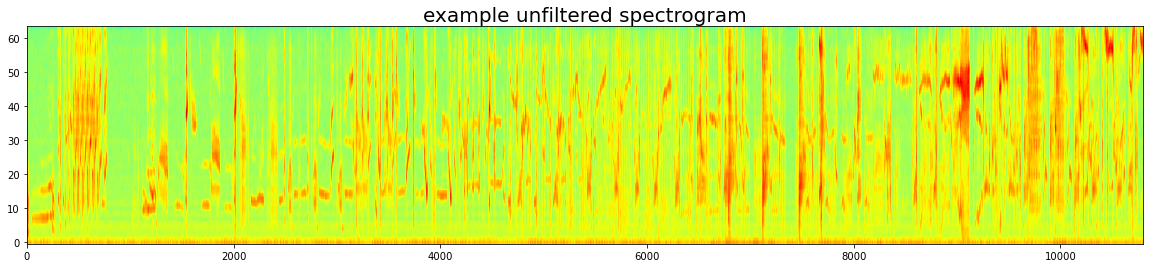

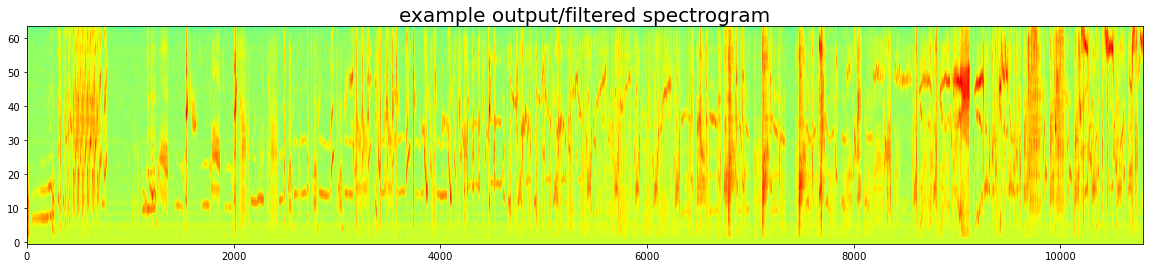

In [19]:
#look at your spectograms before and after!
example_num = 0
colors = 'jet' #inferno & jet are good options 

#plot untouched spectrogram
stim_test = spectrograms_all[example_num]
plt.figure(figsize=(20, 4))
plt.title('example unfiltered spectrogram', fontsize = 20)
plt.imshow(stim_test, cmap = colors, origin='lower', aspect='auto', interpolation=None)
print(stim_test.shape)

#plot filtered spectrogram
stim_test1 = stim_spectrograms[example_num]
plt.figure(figsize=(20, 4))
plt.title('example output/filtered spectrogram', fontsize = 20)
plt.imshow(stim_test1, cmap = colors , origin='lower', aspect='auto', interpolation=None)
print(stim_test1.shape)

# FIT MNE Parameters
### MNE stims and responses, response predictions, and shuffled responses
### skip this if you just want to load the data

In [20]:
#####################################################
# compute shuffle response tensors
# stim_mne_segs; resp_mne

# fully shuffle each stimulus response tensor
fs_stim_responses = [MNE2.full_shuffle_response(x) for x in stim_responses]

# mask shuffle each stimulus response tensor
ms_stim_responses = [MNE2.mask_shuffle_response(x) for x in stim_responses]

# permute time bins across all stims, same for each trial
ps_stim_responses = MNE2.permute_all_stim_time_bins(stim_responses)

#####################################################

# different variations on the response
# just do original and shuffled responses
response_classes = [stim_responses, fs_stim_responses]

# the question is do I concatenate all the stimuli and responses and then split into training and test, 
# or do I pull out training and test *whole stimuli* and then concatenate each.  
# the problem with the latter is that it's not gauranteed that the training and test sets
# have the same number of data points for each iteration. 

# Canonical order of operations:
# extract_stim_resp
# do shuffling
# kozlov_avg_stim_resp
# segment_stim_resp
# reshape_stim_segments
# preprocess_MNE

# og = original
# fs = fullshuffle
# ms = mask shuffle
# ps = permute time bins across all stims, same permutation for each trial

#this takes alist of spectrograms and responses (one for each bout) and averages rows and columns of the 
#spectrogram pariwise for the number of times defined by avg_nrows and avg_ncols 
#step 1 is to prepfrom Kozlov Aaveraging, where you average 2 along rows (freqency bins) and three times across columns (time bins)
#step 2 is to get sums of spike counts not averages, so multipying by the number of bins we average over
kozlov_stim_responses = [MNE2.kozlov_avg_stim_resp(stim_spectrograms, x, avg_nrows, avg_ncols) for x in response_classes]

#this breaks the stimulus spectrogram into segements that precede each respnse time bin and transposes them into (n_time x n_cell x ntrial)
#this is also where you indicate which "way" you want your MNE to go 
#returns bins for the stim and resp to put into the MNE
stim_response_segments = [MNE2.segment_stim_resp(x[0], x[1], nsegbins=nsegbins, mode='forward') for x in kozlov_stim_responses]

#this just reshapes the stim segments from (n_freq x n_segbins) into n_dim x 1 where n_dim = n_freq * n_segbins
stim_response_segments_reshape = [(MNE2.reshape_stim_segments(x[0]), x[1]) for x in stim_response_segments]

#the input x[0] in a list of stimulus spectrogram segments
#x[1] is a list of resposne tensors/spike counts 
#this cocatentes stimuli normalized to the sphere and bnary response vectors 
stim_resp_mne = [MNE2.preprocess_MNE(x[0], x[1], radius) for x in stim_response_segments_reshape]

#THIS IS WHERE THE TRAIN AND TEST SETS HAPPEN 
#currently set up as prepare_MNE_train_test_set(stim_mne, resp_mne, train_pct=0.8, zscore=True, kz_norm_resp=False)
# output: for each class, we have: (stim train, resp train, stim test, resp test)
stim_resp_mne_train_test = [MNE2.prepare_MNE_train_test_set(x[0], x[1], zscore=True) for x in stim_resp_mne]

#have another thing/pickle file to save the test set in then make another notebook to do the other stuff 

58502
58502


(64, 10799)
(16, 1349)


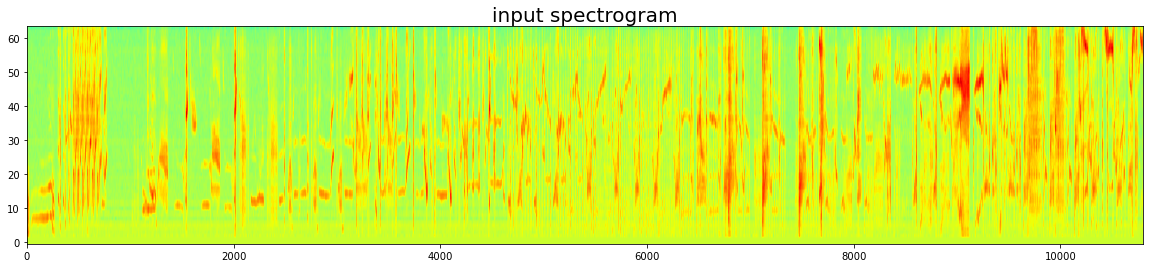

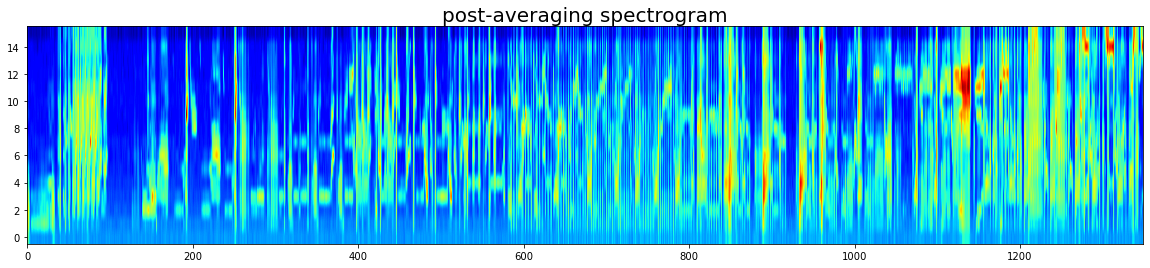

In [21]:
example_num = 0
colors = 'jet' #inferno & jet are good options 

#plot filtered input spectrogram
stim_test1 = stim_spectrograms[example_num]
plt.figure(figsize=(20, 4))
plt.title('input spectrogram', fontsize = 20)
plt.imshow(stim_test1, cmap = colors, origin='lower', aspect='auto', interpolation=None)
print(stim_test1.shape)

#plot post-averaging spectrogram
stim_test2 = kozlov_stim_responses[0][0][example_num]
plt.figure(figsize=(20, 4))
plt.title('post-averaging spectrogram', fontsize = 20)
plt.imshow(stim_test2, cmap = colors, origin='lower', aspect='auto', interpolation=None)
print(stim_test2.shape)


In [ ]:
#Here is the MNE fit itself!
#this is also where the jacknives come into play - see code below
# def fit_MNE(stims_train, resps_train, order=2):
#     pfinals_jackknives = MNEfit_jackknives(stims_train, resps_train, order=order)
#     # average jackknives
#     pfinal = np.mean(pfinals_jackknives, axis=0)
#     return pfinal

mne_results = []
full_mne_results = []
for r_class in stim_resp_mne_train_test:
    print('Fitting MNE...')
    stims_train, resps_train, stims_test, resps_test = r_class
    mne_res = Parallel(n_jobs=20)(delayed(MNE2.fit_MNE)(stims_train, resps_train[:, idx][:, np.newaxis], order=2) for idx in range(n_cells))
    print('MNE fit done')
    mne_results.append(mne_res)

In [ ]:
# Save MNE parameter fit results, the preprocessed stimuli, and the shuffled responses
results_dict = {'bird': bird, 
                'sess' : sess,
                'probe' : probe,
                'sort' : sort,
                'units': clusters, 
                'nsegbins': nsegbins, 
                'n_rows_avg':avg_nrows, 
                'n_cols_avg':avg_ncols, 
                'stim_resp': stim_resp_mne_train_test,
                'results': mne_results, 
                'stim_names':np.array(stim_names, dtype='object'), 
                'stim_spectrograms': stim_spectrograms,
                'stim_response_classes': response_classes,
                'stim_zscore_thresh': stim_zscore_thresh}

print('Saving results...')
with open(output_file_mne_pfinal, 'wb') as f:
    pickle.dump(results_dict, f)
print('Done')

# Plot MNES

In [ ]:
original_pfinals = mne_results[0]
tags = []
for num in clu_list_ra_all:
    tags.append(clu_df['KSLabel'][num])
# tags_df = pd.DataFrame(tags)
# pd.set_option('display.max_rows', tags_df.shape[0]+1)
# #print(tags_df[0])
# print(tags[0])

def plot_MNE(pfinal, unit, bird, block, n_eigvec_to_display=6, sdim=256, rf_shape=(16,16), color_map='jet', figure_output_path=None):

    ''' 
    This function produces the MNE summary plot given a list of MNE output parameters (pfinals)
    '''

    interp = None

    a_avg = pfinal[0]
    h_avg = np.reshape(pfinal[1:sdim+1], rf_shape)
    j_avg = np.reshape(pfinal[-sdim*sdim:], (sdim, sdim))
    

    eigval, eigvec = np.linalg.eig(j_avg)
    # display recovered rf to generative rf
    eigval_ixd = [(eigval[i],i) for i in range(len(eigval))]
    eigval_ixd.sort()
    sorted_eigval, permt = zip(*eigval_ixd)


    topn_negative = [np.reshape(eigvec[:, permt[x]], rf_shape) for x in range(n_eigvec_to_display)]
    topn_positive = [np.reshape(eigvec[:, permt[x]], rf_shape) for x in range(-1, -(n_eigvec_to_display+1), -1)]


    fig = plt.figure(constrained_layout=True, figsize=(13.3, 10))
    gs = fig.add_gridspec(4, n_eigvec_to_display)

    neg_axs = []
    pos_axs = []
    for idx, v in enumerate(topn_negative):
        ax = fig.add_subplot(gs[2 +idx//3, idx%3])
        neg_axs.append(ax)
        ax.imshow(v, cmap=color_map, interpolation=interp, origin='lower', aspect='equal')
        ax.set_title('{:.3f}'.format(sorted_eigval[idx]), fontsize=14)
        ax.tick_params(labelbottom=False, labelleft=False, direction='in', bottom=False, left=False)


    for idx, v in enumerate(topn_positive):
        ax = fig.add_subplot(gs[2 + idx//3, idx%3 +3])
        neg_axs.append(ax)
        ax.imshow(v, cmap=color_map, interpolation=interp, origin='lower', aspect='equal')
        ax.set_title('{:.3f}'.format(sorted_eigval[-(idx+1)]), fontsize=14)
        ax.tick_params(labelbottom=False, labelleft=False, direction='in', bottom=False, left=False)


    ax_eigs = fig.add_subplot(gs[0:2, 3:])
    ax_eigs.plot(sorted_eigval, 'k.')
    #ax_eigs.plot(sorted_eigval[:n_eigvec_to_display], 'rx')
    #ax_eigs.plot(range(sdim-n_eigvec_to_display, sdim+1), sorted_eigval[-(n_eigvec_to_display+1):], 'rx')
    ax_eigs.set_title('Sorted Eigenvalues of J Matrix', fontsize=18)
    ax_eigs.set_ylabel('Value', fontsize=16)
    ax_eigs.set_xlabel('Index', fontsize=16)
    ax_eigs.tick_params(labelsize=14)

    ax_a = fig.add_subplot(gs[0:2, :3])
    ax_a.imshow(h_avg, cmap=color_map, interpolation=interp, origin='lower', aspect='equal')
    ax_a.set_title('Linear Feature', fontsize=18)
    ax_a.tick_params(labelbottom=False, labelleft=False, direction='in', bottom=False, left=False)
    tag = tags[unit]
    fig.suptitle("{} Block: {} Unit: {} KSLabel: {}".format(bird, block, unit, tag), fontsize=20)
    
    return fig 


In [ ]:
len(original_pfinals)

In [ ]:
for unit, pfinal in enumerate(original_pfinals):
    plot_MNE(pfinal, unit, bird, sess, n_eigvec_to_display=6, sdim=256, rf_shape=(16,16), color_map='jet', figure_output_path=None)

In [ ]:
# full shuffled
for unit, pfinal in enumerate(mne_results[1]):
    plot_MNE(pfinal, unit, bird, sess, n_eigvec_to_display=6, sdim=256, rf_shape=(16,16), color_map='jet', figure_output_path=None)

## Save Individual Output MNEs

In [ ]:
def plot_MNE_saveindividual(pfinal, unit, bird, block, n_eigvec_to_display=6, sdim=256, rf_shape=(16,16), color_map='jet', figure_output_path=None):

    ''' 
    This function produces the MNE summary plot given a list of MNE output parameters (pfinals)
    '''

    interp = None

    a_avg = pfinal[0]
    h_avg = np.reshape(pfinal[1:sdim+1], rf_shape)
    j_avg = np.reshape(pfinal[-sdim*sdim:], (sdim, sdim))
    

    eigval, eigvec = np.linalg.eig(j_avg)
    # display recovered rf to generative rf
    eigval_ixd = [(eigval[i],i) for i in range(len(eigval))]
    eigval_ixd.sort()
    sorted_eigval, permt = zip(*eigval_ixd)


    topn_negative = [np.reshape(eigvec[:, permt[x]], rf_shape) for x in range(n_eigvec_to_display)]
    topn_positive = [np.reshape(eigvec[:, permt[x]], rf_shape) for x in range(-1, -(n_eigvec_to_display+1), -1)]


    fig = plt.figure(constrained_layout=True, figsize=(13.3, 10))
    gs = fig.add_gridspec(4, n_eigvec_to_display)

    neg_axs = []
    pos_axs = []
    for idx, v in enumerate(topn_negative):
        ax = fig.add_subplot(gs[2 +idx//3, idx%3])
        neg_axs.append(ax)
        ax.imshow(v, cmap=color_map, interpolation=interp, origin='lower', aspect='equal')
        ax.set_title('{:.3f}'.format(sorted_eigval[idx]), fontsize=24)
        ax.tick_params(labelbottom=False, labelleft=False, direction='in', bottom=False, left=False)


    for idx, v in enumerate(topn_positive):
        ax = fig.add_subplot(gs[2 + idx//3, idx%3 +3])
        neg_axs.append(ax)
        ax.imshow(v, cmap=color_map, interpolation=interp, origin='lower', aspect='equal')
        ax.set_title('{:.3f}'.format(sorted_eigval[-(idx+1)]), fontsize=24)
        ax.tick_params(labelbottom=False, labelleft=False, direction='in', bottom=False, left=False)


    ax_eigs = fig.add_subplot(gs[0:2, 3:])
    ax_eigs.plot(sorted_eigval, 'k.')
    #ax_eigs.plot(sorted_eigval[:n_eigvec_to_display], 'rx')
    #ax_eigs.plot(range(sdim-n_eigvec_to_display, sdim+1), sorted_eigval[-(n_eigvec_to_display+1):], 'rx')\
    ax_eigs.axhline(y = 0, color = 'black', linestyle = '-', linewidth = 1.5)
    ax_eigs.set_title('Sorted Eigenvalues of J Matrix', fontsize=30)
    ax_eigs.set_ylabel('Value', fontsize=32)
    ax_eigs.set_xlabel('Index', fontsize=32)
    ax_eigs.tick_params(labelsize=20)

    ax_a = fig.add_subplot(gs[0:2, :3])
    ax_a.imshow(h_avg, cmap=color_map, interpolation=interp, origin='lower', aspect='equal')
    ax_a.set_title('Linear Feature', fontsize=32)
    ax_a.tick_params(labelbottom=False, labelleft=False, direction='in', bottom=False, left=False)
    tag = tags[unit]
    fig.suptitle("{} Block: {} Unit: {} KSLabel: {}".format(bird, block, unit, tag), fontsize=38)
 #   plt.savefig('/mnt/cube/lstanwic/reducted_data/z_r12r13_21/oneMNE.png', dpi=300, bbox_inches='tight', transparent=True)

    
    return fig 
# unit = 8
# pfinal = original_pfinals[unit]
# plot_MNE_saveindividual(pfinal, unit, bird, sess, n_eigvec_to_display=6, sdim=256, rf_shape=(16,16), color_map='jet', figure_output_path=None)
# plt.savefig('/mnt/cube/lstanwic/reducted_data/s_b1253_21/oneMNE.png', dpi=300, bbox_inches='tight', transparent=True)

In [ ]:

unit = 14
pfinal = original_pfinals[unit]
plot_MNE_saveindividual(pfinal, unit, bird, sess, n_eigvec_to_display=6, sdim=256, rf_shape=(16,16), color_map='jet', figure_output_path=None)
plt.savefig('/mnt/cube/lstanwic/reducted_data/s_/oneMNE.png', dpi=300, bbox_inches='tight', transparent=True)

-----
# Load MNE results
#### you can do this instead of fitting the MNE above every time for the same data, but you have to run some of the setup lines of code at the beginning
#### just follow the errors, you will figure it out

In [ ]:
# load previously computed parameters / results


#output_file_mne_pfinal = os.path.join(exp_path, 'MNE_pfinal_res_b.pkl')


# contains stim spectrograms and response class matrices
with open(output_file_mne_pfinal, 'rb') as f:
    results_dict_pfinal = pickle.load(f)


n_cells = len(results_dict_pfinal['units'])

# pfinals
# this is by class
mne_results = results_dict_pfinal['results']
print(len(mne_results))

# spectrograms and responses
stim_spectrograms = results_dict_pfinal['stim_spectrograms']
response_classes = results_dict_pfinal['stim_response_classes']
avg_nrows = results_dict_pfinal['n_rows_avg']
avg_ncols = results_dict_pfinal['n_cols_avg']
nsegbins = results_dict_pfinal['nsegbins']

kozlov_stim_responses = [MNE2.kozlov_avg_stim_resp(stim_spectrograms, x, avg_nrows, avg_ncols) for x in response_classes]

stim_response_segments = [MNE2.segment_stim_resp(x[0], x[1], nsegbins=nsegbins, mode='forward') for x in kozlov_stim_responses]

stim_response_segments_reshape = [(MNE2.reshape_stim_segments(x[0]), x[1]) for x in stim_response_segments]

stim_resp_mne = [MNE2.preprocess_MNE(x[0], x[1], radius) for x in stim_response_segments_reshape]
